<a href="https://colab.research.google.com/github/hussainmudassir/LLD/blob/main/dls23_hw2_prob5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-wmi3vthw
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-wmi3vthw
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


In [6]:
%%shell

wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2023-03-10 22:35:38--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  10.9MB/s    in 5.8s    

2023-03-10 22:35:45 (8.89 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-03-10 22:35:45--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-03-10 22:35:45--
Total wall clock time: 6.7s
Downloaded: 1 files, 51M in 5.8s (8.89 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [7]:
import os
import torch
import torch.utils.data
import torchvision
import numpy as np
from PIL import Image
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [8]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

**a)** 
The tutorial shows how to finetune a pretrained model (what they
call option 1). Now, follow their approach to add a different backbone
(option 2). You can use the same dataset (and code) as the tutorial.

**Option 1** : A model pre-trained on COCO and finetune it for our particular classes. To also compute the instance segmentation masks, we will be using Mask R-CNN:

In [9]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

**Option 2:** Modifying the model to add a different backbone

In [10]:
def get_instance_segmentation_model_backbone(num_classes):
    # load a pre-trained model for classification and return
    backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
    backbone.out_channels = 1280

    
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))
    
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    
    
    # put the pieces together inside a FasterRCNN model
    model = MaskRCNN(backbone,
                    num_classes=2,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)


    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [11]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 316973, done.
remote: Total 316973 (delta 0), reused 0 (delta 0), pack-reused 316973
Receiving objects: 100% (316973/316973), 644.02 MiB | 18.14 MiB/s, done.
Resolving deltas: 100% (291349/291349), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [12]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

**b)** How do the performance of the two models compare on the training
data after 10 epochs?

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the res_net model using our helper function
mode_resnet = get_instance_segmentation_model(num_classes)
# move model to the right device
mode_resnet.to(device)

# construct an optimizer
params = [p for p in mode_resnet.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Evaluating resnet:

In [16]:
# let's train it for 10 epochs
# from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(mode_resnet, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(mode_resnet, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:08:24  lr: 0.000090  loss: 2.7899 (2.7899)  loss_classifier: 0.7401 (0.7401)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 8.4020  data: 0.4142  max mem: 2162
Epoch: [0]  [10/60]  eta: 0:01:05  lr: 0.000936  loss: 1.3930 (1.7268)  loss_classifier: 0.5146 (0.4824)  loss_box_reg: 0.2960 (0.2981)  loss_mask: 0.7157 (0.9198)  loss_objectness: 0.0169 (0.0217)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 1.3125  data: 0.0469  max mem: 3320
Epoch: [0]  [20/60]  eta: 0:00:38  lr: 0.001783  loss: 1.0074 (1.2310)  loss_classifier: 0.2239 (0.3357)  loss_box_reg: 0.2910 (0.2865)  loss_mask: 0.3240 (0.5872)  loss_objectness: 0.0109 (0.0171)  loss_rpn_box_reg: 0.0042 (0.0045)  time: 0.5801  data: 0.0096  max mem: 3320
Epoch: [0]  [30/60]  eta: 0:00:25  lr: 0.002629  loss: 0.5572 (1.0159)  loss_classifier: 0.0985 (0.2551)  loss_box_reg: 0.2665 (0.2869)  loss_mask: 0.1832 (0.4537)  loss_ob

Evaluating MobileNetV2:

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model_new using our helper function
model_mobileNetV2 = get_instance_segmentation_model_backbone(num_classes)
# move model_new to the right device
model_mobileNetV2.to(device)

# construct an optimizer
params = [p for p in model_mobileNetV2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [18]:
# let's train it for 10 epochs
# from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_mobileNetV2, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_mobileNetV2, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:13  lr: 0.000090  loss: 4.1255 (4.1255)  loss_classifier: 0.6963 (0.6963)  loss_box_reg: 0.0427 (0.0427)  loss_mask: 2.6574 (2.6574)  loss_objectness: 0.7006 (0.7006)  loss_rpn_box_reg: 0.0284 (0.0284)  time: 1.2278  data: 0.3785  max mem: 3775
Epoch: [0]  [10/60]  eta: 0:00:22  lr: 0.000936  loss: 3.9352 (3.8392)  loss_classifier: 0.6483 (0.6180)  loss_box_reg: 0.0427 (0.0508)  loss_mask: 2.6380 (2.4390)  loss_objectness: 0.6895 (0.6857)  loss_rpn_box_reg: 0.0413 (0.0458)  time: 0.4492  data: 0.0423  max mem: 5339
Epoch: [0]  [20/60]  eta: 0:00:17  lr: 0.001783  loss: 2.7765 (3.0954)  loss_classifier: 0.3964 (0.4574)  loss_box_reg: 0.0695 (0.0823)  loss_mask: 1.6116 (1.8683)  loss_objectness: 0.6556 (0.6441)  loss_rpn_box_reg: 0.0472 (0.0433)  time: 0.3851  data: 0.0102  max mem: 5340
Epoch: [0]  [30/60]  eta: 0:00:12  lr: 0.002629  loss: 1.8807 (2.6839)  loss_classifier: 0.2810 (0.4131)  loss_box_reg: 0.1421 (0.1297)  loss_mask: 0.8534 (1.5194)  loss_ob

Evaluation result of MobilenetV2:
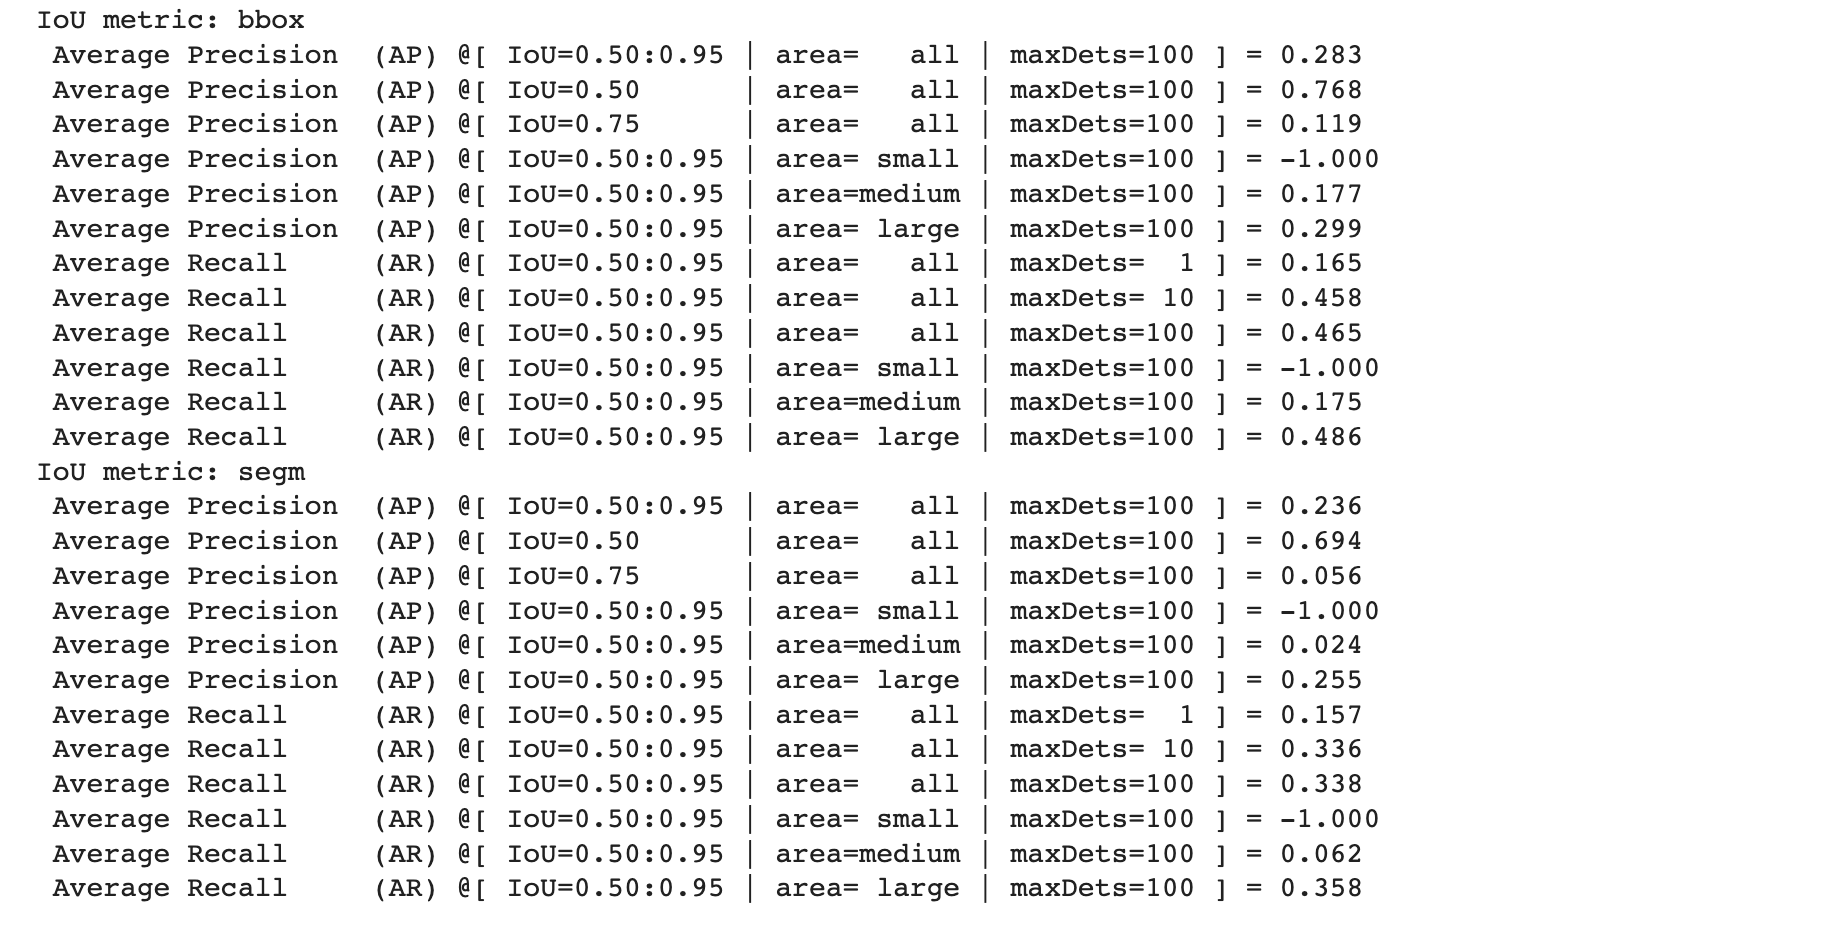
Evaluation result of resnet:
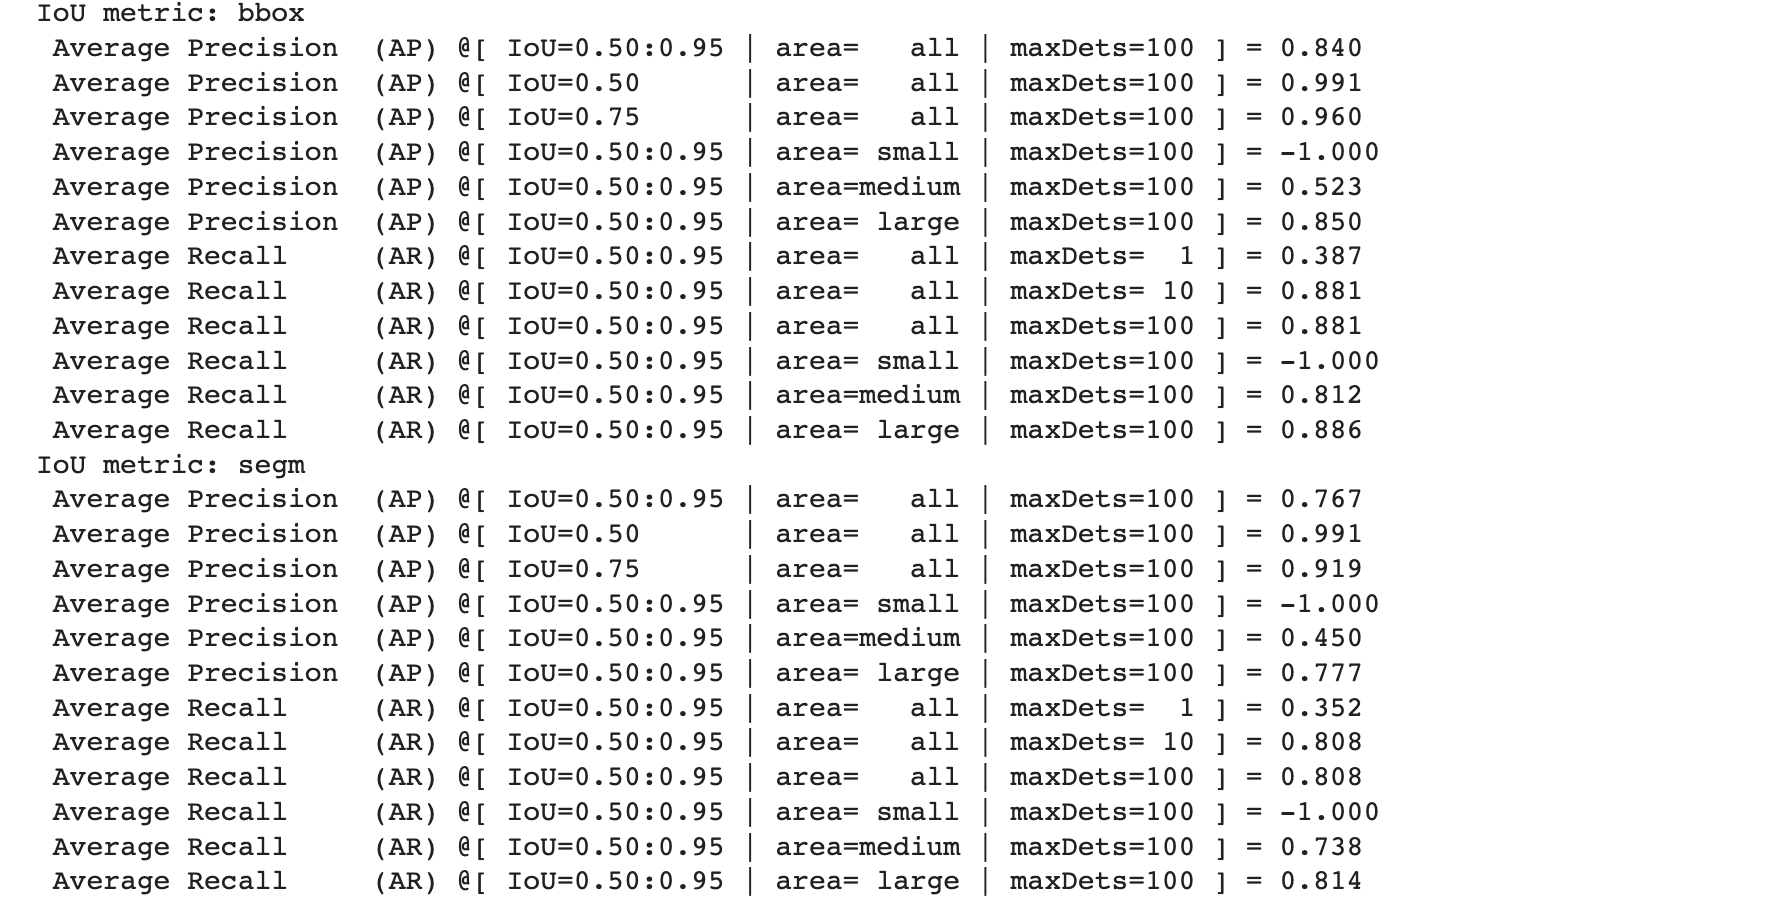

The results represent the performance of object detection models on a specific dataset. The evaluation is done using two metrics: bbox (bounding box) and segm (segmentation) metrics.

The bbox metric measures the accuracy of the model in localizing the objects by computing the intersection over union (IoU) between the predicted bounding boxes and the ground truth boxes. The results show the average precision (AP) and average recall (AR) at different IoU thresholds (0.5, 0.75, and 0.5:0.95) for different object sizes (small, medium, and large).

The segm metric measures the accuracy of the model in localizing and segmenting the objects. The results show the AP and AR at different IoU thresholds and object sizes.

In the first set of results, the model has low performance on both metrics, with negative AP scores for small objects in the bbox metric. The model has a better performance on the larger objects in the bbox metric, with a higher AP and AR scores for the large objects. In the segm metric, the model has a low performance for all object sizes.

In the second set of results, the model has a much better performance on both metrics, with high AP and AR scores for all object sizes in the bbox metric, and higher scores for the medium and large objects in the segm metric. The model achieved a perfect AP score for the IoU=0.5 threshold in the bbox metric, indicating that it is able to accurately predict the object locations. The high AP and AR scores in both metrics indicate that the model is able to accurately detect and segment the objects in the dataset.

**c)** Test both models on this image of the Beatles. Be careful to make
sure the dimensions align and the scaling is similar. How do the two
models compare in terms of performance on this image?

In [19]:
!wget https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg -O Beatles.jpg

--2023-03-10 23:11:01--  https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114980 (112K) [image/jpeg]
Saving to: ‘Beatles.jpg’

Beatles.jpg         100%[===================>] 112.29K  --.-KB/s    in 0.004s  

2023-03-10 23:11:01 (27.1 MB/s) - ‘Beatles.jpg’ saved [114980/114980]



In [20]:
from torchvision.transforms import transforms

trans = transforms.ToTensor()
image = Image.open('./Beatles.jpg')
img = trans(image)

In [21]:
# put the model in evaluation mode
mode_resnet.eval()
with torch.no_grad():
  prediction = mode_resnet([img.to(device)])
prediction

[{'boxes': tensor([[ 91.1214, 165.2242, 145.4066, 273.2227],
          [ 21.7529, 161.5251,  80.0944, 271.0924],
          [149.4718, 168.0715, 216.6571, 286.6968],
          [223.0056, 165.2356, 282.6017, 282.9541],
          [239.2751, 148.2048, 245.2302, 173.0940],
          [ 45.7823, 163.1525, 246.5053, 274.8724],
          [112.8500, 161.0511, 199.3988, 275.1010]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9862, 0.9828, 0.9658, 0.9472, 0.4945, 0.1220, 0.0500],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ..

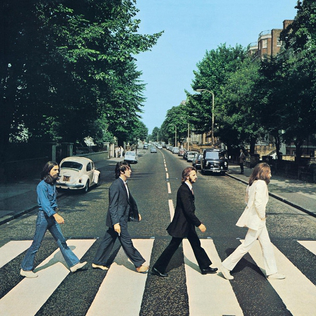

In [22]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

<ipython-input-23-c082b1b4a76e>:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  show_corner_bb(img.T, bb_hat)


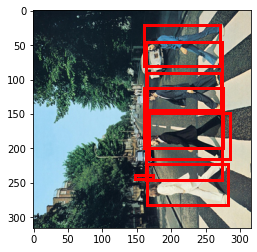

In [23]:
#drawing the 
import matplotlib.pyplot as plt

def rec(bounding_box, color='red'):
    bounding_box = np.array(bounding_box, dtype=np.float32)
    return plt.Rectangle((bounding_box[1], bounding_box[0]), bounding_box[3]-bounding_box[1], bounding_box[2]-bounding_box[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    for box in bb:
       plt.gca().add_patch(rec(box))

bb_hat = prediction[0]['boxes'].detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(img.T, bb_hat)

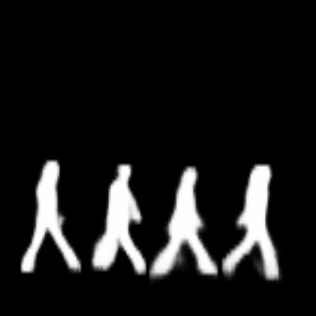

In [24]:
Image.fromarray(torch.sum(prediction[0]['masks'][prediction[0]['scores'] > 0.5],0)[0].mul(255).byte().cpu().numpy())

In [25]:
# put the model in evaluation mode
model_mobileNetV2.eval()
with torch.no_grad():
    prediction_mobileNetV2 = model_mobileNetV2([img.to(device)])
prediction_mobileNetV2

[{'boxes': tensor([[146.8168, 168.0250, 223.5514, 316.0000],
          [221.6135, 159.8856, 292.2544, 316.0000],
          [ 82.8231, 167.3264, 159.6399, 316.0000],
          [183.5074, 299.9081, 201.8994, 309.0180],
          [ 32.1409, 296.9487,  44.2832, 310.2077],
          [181.8736, 295.7674, 195.2788, 309.4464],
          [  7.5634, 153.3613,  81.7338, 316.0000],
          [ 42.9164, 157.4126, 313.0022, 316.0000],
          [ 22.9828, 292.2280,  48.2122, 316.0000],
          [ 31.1509, 278.2198,  49.3304, 316.0000]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.3840, 0.3727, 0.2227, 0.1148, 0.0935, 0.0868, 0.0855, 0.0732, 0.0578,
          0.0560], device='cuda:0'),
  'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.0000, 0.0

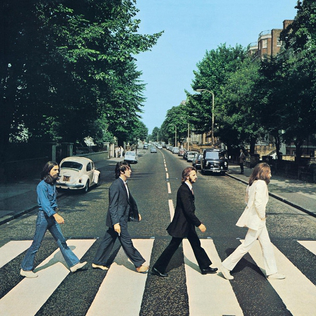

In [26]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

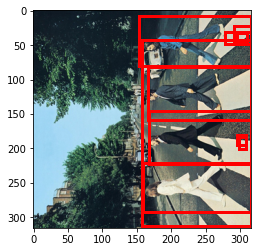

In [27]:
#drawing the 
import matplotlib.pyplot as plt

def rec(bounding_box, color='red'):
    bounding_box = np.array(bounding_box, dtype=np.float32)
    return plt.Rectangle((bounding_box[1], bounding_box[0]), bounding_box[3]-bounding_box[1], bounding_box[2]-bounding_box[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    for box in bb:
       plt.gca().add_patch(rec(box))

bb_hat = prediction_mobileNetV2[0]['boxes'].detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(img.T, bb_hat)

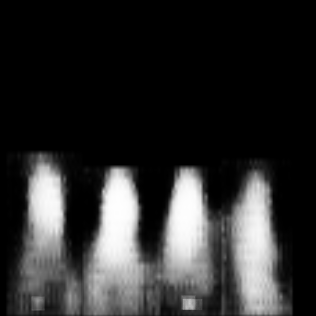

In [41]:
Image.fromarray(torch.sum(prediction_mobileNetV2[0]['masks'][prediction_mobileNetV2[0]['scores'] > 0.08],0)[0].mul(255).byte().cpu().numpy())

MobileNet_V2 model has low performance on both metrics, with negative AP scores for small objects in the bbox metric. The model has a better performance on the larger objects in the bbox metric, with a higher AP and AR scores for the large objects. In the segm metric, the model has a low performance for all object sizes.

ResNet50 model has a much better performance on both metrics, with high AP and AR scores for all object sizes in the bbox metric, and higher scores for the medium and large objects in the segm metric. The model achieved a perfect AP score for the IoU=0.5 threshold in the bbox metric, indicating that it is able to accurately predict the object locations. The high AP and AR scores in both metrics indicate that the model is able to accurately detect and segment the objects in the dataset.